In [10]:
import numpy as np
import cupy as cp
from holotomocupy.utils import *
from holotomocupy.holo import G,GT
from holotomocupy.shift import S,ST
from holotomocupy.tomo import R
from holotomocupy.chunking import gpu_batch
import cv2
import xraylib
%matplotlib inline

np.random.seed(1) # fix randomness

# Init data sizes and parametes of the PXM of ID16A

In [11]:
n = 2048  # object size in each dimension

noise = 0
z1c = -19.5e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

center = n/2 # rotation axis
npos = 10  # number of code positions
detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0# np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1c
distances2 = (z1-z1c)/(z1c/z1)#magnifications2
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = n+2*pad

show = True



flg = f'{n}_{z1c}'
path = f'/data2/vnikitin/nfp_codes'



### Form the transmittance function for a siemens star

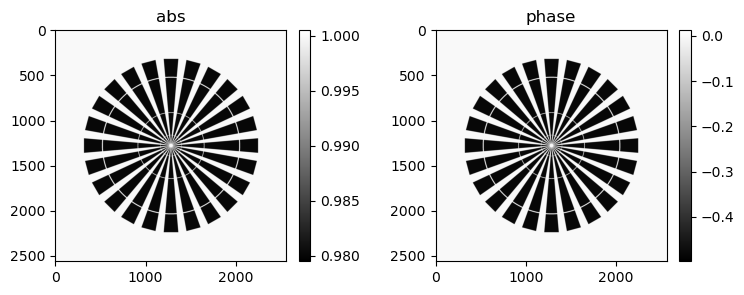

In [12]:
img = np.zeros((ne, ne, 3), np.uint8)
triangle = np.array([(ne//8, ne//2-ne//32), (ne//8, ne//2+ne//32), (ne//2-ne//128, ne//2)], np.float32)
star = img[:,:,0]*0
for i in range(0, 360, 15):
    img = np.zeros((ne, ne, 3), np.uint8)
    degree = i
    theta = degree * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]], np.float32)    
    rotated = cv2.gemm(triangle-ne//2, rot_mat, 1, None, 1, flags=cv2.GEMM_2_T)+ne//2
    cv2.fillPoly(img, [np.int32(rotated)], (255, 0, 0))
    star+=img[:,:,0]
[x,y] = np.meshgrid(np.arange(-ne//2,ne//2),np.arange(-ne//2,ne//2))
x = x/ne*2
y = y/ne*2
# add holes in triangles
circ = (x**2+y**2>0.355)+(x**2+y**2<0.345)
circ *= (x**2+y**2>0.083)+(x**2+y**2<0.08)
circ *= (x**2+y**2>0.0085)+(x**2+y**2<0.008)
star = star*circ/255

v = np.arange(-ne//2,ne//2)/ne
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-5*(vx**2+vy**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(star)))
star = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = 1e-6/voxelsize # siemens star thickness in pixels
# form Transmittance function
u = star*(-delta+1j*beta) # note -delta
Ru = u*thickness 
psi = np.exp(1j * Ru * voxelsize * 2 * np.pi / wavelength)[np.newaxis].astype('complex64')


mshow_polar(psi[0],show)

## Read the probe, original one 

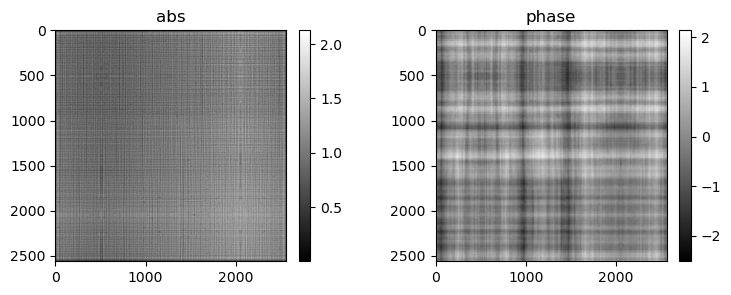

In [13]:
prb = np.load(f'{path}/prb_{flg}.npy')
mshow_polar(prb[0],show)

### Read original coded aperture

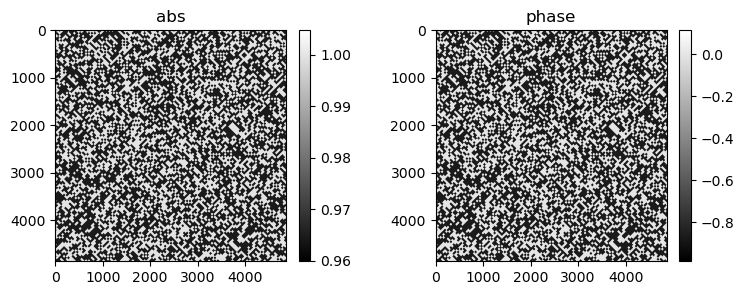

In [14]:
code = np.load(f'{path}/code_{flg}.npy')
mshow_polar(code[0],show)

### Shifts of the code

In [15]:
# shifts of codes
shifts_code = np.round((np.random.random([1, npos, 2]).astype('float32')-0.5)*ne/4)

#### Forward operator

In [16]:
def Lop(psi):
    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def Lwop(psi):
    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances2[i])
        data[:, i] = psir
    return data

def Sop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
    
        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data


# Apply the forward transform
psi = cp.array(psi)
prb = cp.array(prb)
code = cp.array(code)
shifts_code = cp.array(shifts_code)

fpsi = Lop(psi*Lwop(Sop(code)*prb))
fref = Lop(Lwop((Sop(code)*0+1)*prb))
print(fref.shape)

(1, 4, 2048, 2048)


### Take squared absolute value to simulate data on the detector

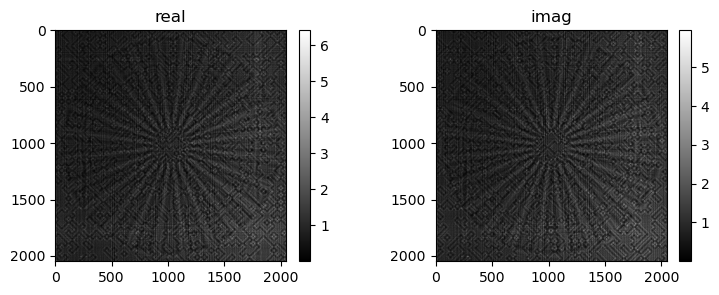

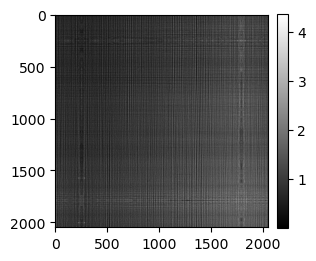

In [17]:
data = np.abs(fpsi)**2
mshow_complex(data[0,0]+1j*data[0,1],show)
ref = np.abs(fref)**2
mshow(ref[0,0],show)

### Save data and code shifts

In [18]:
for k in range(npos):
    write_tiff(data[:,k],f'{path}/data_{k}_{flg}')
    write_tiff(ref[:,k],f'{path}/ref_{k}_{flg}')
np.save(f'{path}/shifts_code_{flg}', shifts_code)

In [25]:
magnifications_c = focusToDetectorDistance/z1c
voxelsize_c = detector_pixelsize/magnifications_c*2048/n  # object voxel size
np.savetxt('shifts_code_siemens.txt',voxelsize_c*1e6*shifts_code[0,:,::-1].get(),fmt='%.8f')

print(voxelsize_c*1e6*shifts_code[0,:,::-1].get())

[[-6.5247135  2.4525518]
 [ 5.8768697 14.807861 ]
 [12.0776615 10.458052 ]
 [ 4.581182   9.3011875]]
